In [1]:
import gradio as gr
import numpy as np
import IPython
from IPython.display import Audio, display
import torch
import librosa, librosa.display
from tqdm import tqdm
from stqdm import stqdm
import json

import sys  
sys.path.insert(0, '../')
from audioldm2 import text_to_audio, build_model, seed_everything, make_batch_for_text_to_audio
from audioldm2.latent_diffusion.modules.diffusionmodules.util import (
    make_ddim_sampling_parameters,
    make_ddim_timesteps,
    noise_like,
    extract_into_tensor,
)
from audioldm2.latent_diffusion.models.ddim import DDIMSampler
from audioldm2.utilities import *
from audioldm2.utilities.audio import *
from audioldm2.utilities.data import *
from audioldm2.utils import default_audioldm_config

from audioldm2.gaverutils import gaver_sounds

from audioldm2.latent_diffusion.modules.attention import SpatialTransformer, CrossAttention

from einops import rearrange, repeat

from scipy.stats import pearsonr, ttest_ind


from interfaces.diffusion_helper_qkv import *


import random

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [4]:
def get_model(model_name):
    print('Loading model')
    
    latent_diffusion = build_model(model_name=model_name)
    latent_diffusion.latent_t_size = int(duration * latent_t_per_second)

    print('Model loaded')
    return latent_diffusion


In [5]:
model_name = 'audioldm_16k_crossattn_t5'
latent_t_per_second=25.6
sample_rate=16000
duration = 10.0 #Duration is minimum 10 secs. The generated sounds are weird for <10secs
guidance_scale = 3
random_seed = 42
n_candidates = 1
batch_size = 1
ddim_steps = 20


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm_16k_crossattn_t5
Loading model on cuda:0
{'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'mel': {'n_mel_channels': 64, 'mel_fmin': 0, 'mel_fmax': 8000}}, 'augmentation': {'mixup': 0}, 'model': {'target': 'audioldm2.latent_diffusion.models.ddpm.LatentDiffusion', 'params': {'first_stage_config': {'base_learning_rate': 8e-06, 'target': 'audioldm2.latent_encoder.autoencoder.AutoencoderKL', 'params': {'sampling_rate': 16000, 'batchsize': 4, 'monitor': 'val/rec_loss', 'image_key': 'fbank', 'subband': 1, 'embed_dim': 8, 'ti

/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


DiffusionWrapper has 265.53 M params.


/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model loaded


In [6]:
def get_word_pairs():
    adjective_noun_pairs = []
    verb_noun_pairs = []

    with open('AudioPairBank/adjective_noun_pairs.txt') as f:
        adjective_noun_pairs_str = f.read()

    with open('AudioPairBank/verb_noun_pairs.txt') as f:
        verb_noun_pairs_str = f.read()

    adjective_noun_pairs = adjective_noun_pairs_str.split("\n")
    verb_noun_pairs = verb_noun_pairs_str.split("\n")

    return np.array(adjective_noun_pairs), np.array(verb_noun_pairs)

adjective_noun_pairs, verb_noun_pairs = get_word_pairs()

In [7]:
len(adjective_noun_pairs), len(verb_noun_pairs)

(759, 359)

In [8]:
def score_wav_text(wav_arr, text, random_seed): #return change in score and pearson corr
    seed_everything(random_seed)
    score_list = []
    for ind, wav in enumerate(wavs):
        wav = torch.from_numpy(wav).unsqueeze(dim=0).cuda()
        target_text = " ".join(text.split("_"))
        
        score = latent_diffusion.clap.cos_similarity(wav, target_text)
        # print(ind, score)
        score_list.append(score.detach().cpu())

    change_in_score = torch.abs(score_list[0] - score_list[-1])
    corr = np.abs(pearsonr(score_list, np.arange(0, len(score_list), 1)).statistic)

    return change_in_score, corr, score_list

# Reweighting

In [9]:
text = "calm atmosphere"
if text[0] in ['a','e','i','o','u']:
    text = "An "+ text
else:
    text = "A "+text

In [10]:
num_bootstrap = 100
num_bootstrap_choices = 50
random_seed = 1947

In [11]:
def create_samples(num_choices=1, type="adjective"):
    pairs_choices = []
    dir_p = ""
    if type == 'adjective':
        pairs_choices = np.random.choice(adjective_noun_pairs, num_choices, replace=False)
        dir_p = os.path.join('samples_reweighting_1', 'adjective_noun')
    else:
        pairs_choices = np.random.choice(verb_noun_pairs, num_choices, replace=False)
        dir_p = os.path.join('samples_reweighting_1', 'verb_noun')

    os.makedirs(dir_p, exist_ok=True)
    for text in sorted(pairs_choices):
        if text is not None and text != "":
            if not os.path.exists(os.path.join(dir_p, text.replace(" ","_")+"_2.wav")):
                print(text)
                describing_word = text.split(" ")[0]
                for i in np.arange(-2,3,1):
                    target_text = text
                    # if target_text[0] in ['a','e','i','o','u']:
                    #     target_text = "An "+ target_text
                    # else:
                    #     target_text = "A "+target_text
                    predicted_wav, _ = sample_diffusion_attention_core(source_text=None, target_text=target_text, random_seed=random_seed, ddim_steps=20,\
                                                                   latent_diffusion=latent_diffusion,
                                                                   interpolation_level = None,
                                                                   interpolate_terms = ['k','v'],
                                                                   target_selected_word_list=[describing_word], target_value_list=[i],
                                                                   disable_tqdmoutput = True
                                                                   )
            
                    fname = text.replace(" ","_")
                    fname += "_"+str(i)+".wav"
                    
                    sf.write(os.path.join(dir_p, fname), predicted_wav, samplerate=16000) 
            else:
                print(text, 'exists')

## Adjective Noun

In [16]:
create_samples(num_choices=len(adjective_noun_pairs), type="adjective")

annoying air exists
annoying alien
annoying computer
annoying glitch
annoying noise exists
annoying siren
annoying sound
annoying speech exists
annoying voice
annoying woman
calm atmosphere
calm autumn
calm background exists
calm beach
calm bird exists
calm car exists
calm city
calm evening
calm forest
calm mood
calm morning exists
calm nature exists
calm noise exists
calm piano
calm spring
calm street
calm summer exists
calm water
calm waves exists
calm wind exists
calm winter exists
calm wood
calm woods exists
chaotic can exists
chaotic cup exists
chaotic garbage
chaotic glitch
chaotic metal
chaotic noise exists
chaotic water
crazy alien
crazy effects exists
crazy glitch
crazy horror
crazy laughter exists
crazy man
crazy noise exists
crazy speech exists
crazy voice
crazy woman exists
creepy alien
creepy atmosphere
creepy background
creepy bird
creepy child
creepy creatures
creepy death
creepy door
creepy drama exists
creepy effect
creepy engine
creepy fear
creepy ghost exists
creepy 

## Verb Noun

In [ ]:
create_samples(num_choices=len(verb_noun_pairs), type="verb")

accelerating car
accelerating engine
accelerating noise
accelerating race
banging army
banging bird
banging bomb


# Evaluate Adjective Nouns

In [13]:
dir_p = os.path.join('samples_reweighting', 'adjective_noun')

adj_noun_list = []
for f in os.listdir(dir_p):
    adj_noun_list.append(" ".join(f.split(".")[0].split("_")[:-1]))

adj_noun_list = np.unique(np.array(adj_noun_list))

print(len(adj_noun_list))
# adj_noun_list = adj_noun_list[:10]

adj_noun_clap_score_change_list = []
adj_noun_perceptual_lin_score_list = []
adj_noun_clap_score_orig_list = []

adj_noun_all_score_list = []


for adj_noun in adj_noun_list:
    wavs = []
    for i in np.arange(-2,3,1):
        fname = os.path.join(dir_p, adj_noun.replace(" ","_")+"_"+str(i)+".wav")
        audio, _ = librosa.load(fname, sr=16000)
        wavs.append(audio)
    change_in_score, perceptual_lin, score_list = score_wav_text(wavs, adj_noun, random_seed=random_seed)
    adj_noun_clap_score_change_list.append(change_in_score)
    adj_noun_perceptual_lin_score_list.append(perceptual_lin)
    adj_noun_clap_score_orig_list.append(score_list[-2])

    adj_noun_all_score_list.append(torch.stack(score_list))

adj_noun_clap_score_change_list = torch.stack(adj_noun_clap_score_change_list)
adj_noun_perceptual_lin_score_list = np.array(adj_noun_perceptual_lin_score_list)
adj_noun_clap_score_orig_list = torch.stack(adj_noun_clap_score_orig_list)

adj_noun_all_score_list = torch.stack(adj_noun_all_score_list)
adj_noun_all_score_list_mean = torch.mean(adj_noun_all_score_list, dim=0)
adj_noun_all_score_list_std = torch.std(adj_noun_all_score_list, dim=0)

print("Mean clap score change = ", str(torch.mean(adj_noun_clap_score_change_list).numpy())+"+/-"+str(torch.std(adj_noun_clap_score_change_list).numpy()))
print("Mean clap score orig = ", str(torch.mean(adj_noun_clap_score_orig_list).numpy())+"+/-"+str(torch.std(adj_noun_clap_score_orig_list).numpy()))
print("Mean Corr = ", str(np.mean(adj_noun_perceptual_lin_score_list))+"+/-"+str(np.std(adj_noun_perceptual_lin_score_list)))
print('-----------------------------')
print("All score average per step = ", adj_noun_all_score_list_mean)
print("All score std per step = ", adj_noun_all_score_list_std)
print('-----------------------------')
for ind, adj_noun in enumerate(adj_noun_list):
    print(adj_noun, adj_noun_clap_score_change_list[ind], adj_noun_perceptual_lin_score_list[ind], adj_noun_clap_score_orig_list[ind])

758
Mean clap score change =  0.10805491+/-0.0783886
Mean clap score orig =  0.13221125+/-0.118117005
Mean Corr =  0.6321078785766692+/-0.23182974267568912
-----------------------------
All score average per step =  tensor([0.0965, 0.1026, 0.1156, 0.1322, 0.1510])
All score std per step =  tensor([0.1196, 0.1188, 0.1165, 0.1181, 0.0521])
-----------------------------
annoying air tensor(0.2029) 0.8531864271866256 tensor(0.0294)
annoying alien tensor(0.0630) 0.5202477309403787 tensor(0.2409)
annoying computer tensor(0.1282) 0.6364416990876204 tensor(0.0407)
annoying glitch tensor(0.0619) 0.8448231229370277 tensor(0.0556)
annoying noise tensor(0.0077) 0.5433458136945085 tensor(0.1387)
annoying siren tensor(0.3283) 0.9463682282046338 tensor(0.2994)
annoying sound tensor(0.0363) 0.5531382110891636 tensor(0.0583)
annoying speech tensor(0.0172) 0.6617651776693307 tensor(0.0986)
annoying voice tensor(0.1740) 0.6271123027755846 tensor(-0.0355)
annoying woman tensor(0.1478) 0.5077384634288269 t

# Evaluate Verb Noun

In [31]:
seed_everything(random_seed)

In [14]:
dir_p = os.path.join('samples_reweighting', 'verb_noun')

verb_noun_list = []
for f in os.listdir(dir_p):
    verb_noun_list.append(" ".join(f.split(".")[0].split("_")[:-1]))

verb_noun_list = np.unique(np.array(verb_noun_list))

print(len(verb_noun_list))
# verb_noun_list = verb_noun_list[:10]

verb_noun_clap_score_change_list = []
verb_noun_perceptual_lin_score_list = []
verb_noun_clap_score_orig_list = []

verb_noun_all_score_list = []

for verb_noun in verb_noun_list:
    wavs = []
    for i in np.arange(-2,3,1):
        fname = os.path.join(dir_p, verb_noun.replace(" ","_")+"_"+str(i)+".wav")
        audio, _ = librosa.load(fname, sr=16000)
        wavs.append(audio)
    change_in_score, perceptual_lin, score_list = score_wav_text(wavs, verb_noun, random_seed=random_seed)
    verb_noun_clap_score_change_list.append(change_in_score)
    verb_noun_perceptual_lin_score_list.append(perceptual_lin)
    verb_noun_clap_score_orig_list.append(score_list[-2])

    verb_noun_all_score_list.append(torch.stack(score_list))

verb_noun_clap_score_change_list = torch.stack(verb_noun_clap_score_change_list)
verb_noun_perceptual_lin_score_list = np.array(verb_noun_perceptual_lin_score_list)
verb_noun_clap_score_orig_list = torch.stack(verb_noun_clap_score_orig_list)

verb_noun_all_score_list = torch.stack(verb_noun_all_score_list)
verb_noun_all_score_list_mean = torch.mean(verb_noun_all_score_list, dim=0)
verb_noun_all_score_list_std = torch.std(verb_noun_all_score_list, dim=0)

print("Mean clap score change = ", str(torch.mean(verb_noun_clap_score_change_list).numpy())+"+/-"+str(torch.std(verb_noun_clap_score_change_list).numpy()))
print("Mean clap score (w/o reweighting) = ", str(torch.mean(verb_noun_clap_score_orig_list).numpy())+"+/-"+str(torch.std(verb_noun_clap_score_orig_list).numpy()))
print("Mean Corr = ", str(np.mean(verb_noun_perceptual_lin_score_list))+"+/-"+str(np.std(verb_noun_perceptual_lin_score_list)))
print('-----------------------------')
print("All score average per step = ", verb_noun_all_score_list_mean)
print("All score std per step = ", verb_noun_all_score_list_std)
print('-----------------------------')
for ind, verb_noun in enumerate(verb_noun_list):
    print(verb_noun, verb_noun_clap_score_change_list[ind], verb_noun_clap_score_orig_list[ind], verb_noun_perceptual_lin_score_list[ind])

358
Mean clap score change =  0.1399387+/-0.0862741
Mean clap score (w/o reweighting) =  0.11864337+/-0.12583509
Mean Corr =  0.6687448988240438+/-0.22998689948980916
-----------------------------
All score average per step =  tensor([0.0323, 0.0537, 0.0817, 0.1186, 0.1446])
All score std per step =  tensor([0.1155, 0.1188, 0.1111, 0.1258, 0.0407])
-----------------------------
accelerating car tensor(0.2424) tensor(0.1705) 0.9319498787972706
accelerating engine tensor(0.3451) tensor(0.2210) 0.9758252095023632
accelerating noise tensor(0.2123) tensor(0.0055) 0.6604045792274431
accelerating race tensor(0.0929) tensor(0.2113) 0.5672367164961922
banging army tensor(0.0251) tensor(0.2576) 0.03290163398223972
banging bird tensor(0.0455) tensor(0.0961) 0.7222013081879711
banging bomb tensor(0.0594) tensor(0.1886) 0.5914083497143655
banging car tensor(0.2818) tensor(-0.0767) 0.41720187094511096
banging city tensor(0.0420) tensor(0.1808) 0.5441470221014257
banging construction tensor(0.0209) t

# t-test

In [15]:
ttest_ind(adj_noun_all_score_list[:,0], adj_noun_all_score_list[:,-1])

Ttest_indResult(statistic=-11.49615574948808, pvalue=2.197342624311064e-29)

In [16]:
ttest_ind(verb_noun_all_score_list[:,0], verb_noun_all_score_list[:,-1])

Ttest_indResult(statistic=-17.35590079103535, pvalue=1.460549956213432e-56)

# Bootstrapped Adjective Noun scores

In [17]:
bootstrap_clap_score_change_list = []
bootstrap_perceptual_lin_score_list = []
bootstrap_clap_score_orig_list = []

bootstrap_all_score_list_mean = []
for bootstrap_ind in range(num_bootstrap):
    adj_noun_list_ind_choices = np.random.choice(np.arange(len(adj_noun_list)), num_bootstrap_choices, replace=False)
    adj_noun_clap_score_change_sublist = adj_noun_clap_score_change_list[adj_noun_list_ind_choices]
    adj_noun_perceptual_lin_score_sublist = adj_noun_perceptual_lin_score_list[adj_noun_list_ind_choices]
    adj_noun_clap_score_orig_sublist = adj_noun_clap_score_orig_list[adj_noun_list_ind_choices]
    adj_noun_sublist = adj_noun_list[adj_noun_list_ind_choices]

    adj_noun_all_score_sublist = adj_noun_all_score_list[adj_noun_list_ind_choices]

    bootstrap_clap_score_change_list.append(torch.mean(adj_noun_clap_score_change_sublist))
    bootstrap_perceptual_lin_score_list.append(np.mean(adj_noun_perceptual_lin_score_sublist))
    bootstrap_clap_score_orig_list.append(torch.mean(adj_noun_clap_score_orig_sublist))

    bootstrap_all_score_list_mean.append(torch.mean(adj_noun_all_score_sublist, dim=0))


bootstrap_clap_score_change_list = torch.stack(bootstrap_clap_score_change_list)
bootstrap_perceptual_lin_score_list = np.array(bootstrap_perceptual_lin_score_list)
bootstrap_clap_score_orig_list = torch.stack(bootstrap_clap_score_orig_list)
bootstrap_all_score_list_mean = torch.stack(bootstrap_all_score_list_mean)

print("Mean CLAP Score Change = ", torch.mean(bootstrap_clap_score_change_list), torch.std(bootstrap_clap_score_change_list))
print("Mean CLAP Score (w/o reweighting) = ", torch.mean(bootstrap_clap_score_orig_list), torch.std(bootstrap_clap_score_orig_list))
print("Mean CLAP Score Change Ratio = ", torch.mean(bootstrap_clap_score_change_list)/torch.mean(bootstrap_clap_score_orig_list))
print("Mean Perceptual Linearity = ", np.mean(bootstrap_perceptual_lin_score_list), np.std(bootstrap_perceptual_lin_score_list))

print('-----------------------------')
print("All score average per step = ", torch.mean(bootstrap_all_score_list_mean, dim=0), torch.std(bootstrap_all_score_list_mean, dim=0))
print('-----------------------------')


adj_noun_bootstrap_clap_score_change_list = bootstrap_clap_score_change_list
adj_noun_bootstrap_perceptual_lin_score_list = bootstrap_perceptual_lin_score_list
adj_noun_bootstrap_clap_score_orig_list = bootstrap_clap_score_orig_list
adj_bootstrap_all_score_list_mean = bootstrap_all_score_list_mean


Mean CLAP Score Change =  tensor(0.1086) tensor(0.0103)
Mean CLAP Score (w/o reweighting) =  tensor(0.1313) tensor(0.0158)
Mean CLAP Score Change Ratio =  tensor(0.8271)
Mean Perceptual Linearity =  0.6319850417949717 0.029627953404446707
-----------------------------
All score average per step =  tensor([0.0941, 0.1016, 0.1149, 0.1313, 0.1508]) tensor([0.0146, 0.0145, 0.0155, 0.0158, 0.0071])
-----------------------------


# Bootstrapped Verb Noun scores

In [24]:
bootstrap_clap_score_change_list = []
bootstrap_perceptual_lin_score_list = []
bootstrap_clap_score_orig_list = []

bootstrap_all_score_list_mean = []
for bootstrap_ind in range(num_bootstrap):
    verb_noun_list_ind_choices = np.random.choice(np.arange(len(verb_noun_list)), num_bootstrap_choices, replace=False)
    verb_noun_clap_score_change_sublist = verb_noun_clap_score_change_list[verb_noun_list_ind_choices]
    verb_noun_perceptual_lin_score_sublist = verb_noun_perceptual_lin_score_list[verb_noun_list_ind_choices]
    verb_noun_clap_score_orig_sublist = verb_noun_clap_score_orig_list[verb_noun_list_ind_choices]
    verb_noun_sublist = verb_noun_list[verb_noun_list_ind_choices]

    verb_noun_all_score_sublist = verb_noun_all_score_list[verb_noun_list_ind_choices]

    bootstrap_clap_score_change_list.append(torch.mean(verb_noun_clap_score_change_sublist))
    bootstrap_perceptual_lin_score_list.append(np.mean(verb_noun_perceptual_lin_score_sublist))
    bootstrap_clap_score_orig_list.append(torch.mean(verb_noun_clap_score_orig_sublist))

    bootstrap_all_score_list_mean.append(torch.mean(verb_noun_all_score_sublist, dim=0))

bootstrap_clap_score_change_list = torch.stack(bootstrap_clap_score_change_list)
bootstrap_perceptual_lin_score_list = np.array(bootstrap_perceptual_lin_score_list)
bootstrap_clap_score_orig_list = torch.stack(bootstrap_clap_score_orig_list)
bootstrap_all_score_list_mean = torch.stack(bootstrap_all_score_list_mean)

print("Mean CLAP Score Change = ", torch.mean(bootstrap_clap_score_change_list), torch.std(bootstrap_clap_score_change_list))
print("Mean CLAP Score (w/o reweighting) = ", torch.mean(bootstrap_clap_score_orig_list), torch.std(bootstrap_clap_score_orig_list))
print("Mean CLAP Score Change Ratio = ", torch.mean(bootstrap_clap_score_change_list)/torch.mean(bootstrap_clap_score_orig_list))
print("Mean Perceptual Linearity = ", np.mean(bootstrap_perceptual_lin_score_list), np.std(bootstrap_perceptual_lin_score_list))

print('-----------------------------')
print("All score average per step = ", torch.mean(bootstrap_all_score_list_mean, dim=0), torch.std(bootstrap_all_score_list_mean, dim=0))
print('-----------------------------')

verb_noun_bootstrap_clap_score_change_list = bootstrap_clap_score_change_list
verb_noun_bootstrap_perceptual_lin_score_list = bootstrap_perceptual_lin_score_list
verb_noun_bootstrap_clap_score_orig_list = bootstrap_clap_score_orig_list
verb_bootstrap_all_score_list_mean = bootstrap_all_score_list_mean

Mean CLAP Score Change =  tensor(0.1390) tensor(0.0130)
Mean CLAP Score (w/o reweighting) =  tensor(0.1150) tensor(0.0159)
Mean CLAP Score Change Ratio =  tensor(1.2091)
Mean Perceptual Linearity =  0.6679586061300555 0.03152440870193445
-----------------------------
All score average per step =  tensor([0.0310, 0.0506, 0.0784, 0.1150, 0.1441]) tensor([0.0153, 0.0145, 0.0134, 0.0159, 0.0050])
-----------------------------


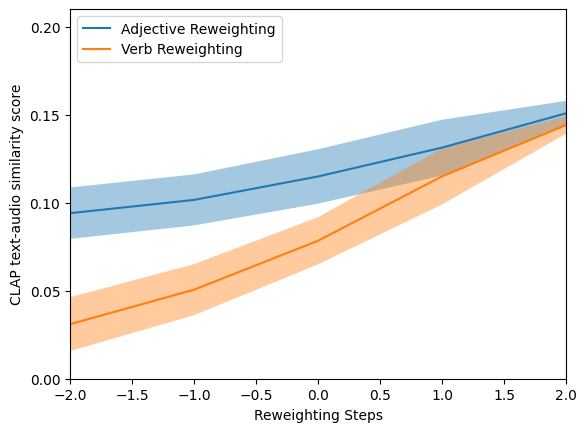

In [25]:
fig, ax = plt.subplots(1)

adj_mean = torch.mean(adj_bootstrap_all_score_list_mean, dim=0)
adj_std = torch.std(adj_bootstrap_all_score_list_mean, dim=0)

verb_mean = torch.mean(verb_bootstrap_all_score_list_mean, dim=0)
verb_std = torch.std(verb_bootstrap_all_score_list_mean, dim=0)

ax.plot(np.arange(-2,3,1), adj_mean,  label='Adjective Reweighting')
ax.fill_between(np.arange(-2,3,1), adj_mean+(adj_std), adj_mean-(adj_std), alpha=0.4)

ax.plot(np.arange(-2,3,1), verb_mean,  label='Verb Reweighting')
ax.fill_between(np.arange(-2,3,1), verb_mean+(verb_std), verb_mean-(verb_std), alpha=0.4)

ax.legend(loc='upper left')
ax.set_xlabel('Reweighting Steps')
ax.set_ylabel('CLAP text-audio similarity score')
ax.set_xlim([-2,2])
ax.set_ylim([-0.0,0.21])
ax.set_yticks([i for i in np.arange(0,0.21,0.05)])